**CHECK GPU AVAILABLE**

In [ ]:
!rm -r sample_data
!nvidia-smi

Sun Feb 27 04:28:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

MOUNT TO DRIVE AND LOAD DATA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


UNZIP DATA

In [ ]:
!unzip /content/drive/MyDrive/skin/ISIC_2019_Training/ISIC_2019_Training_Input.zip -d ./

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./ISIC_2019_Training_Input/ISIC_0065357.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065371.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065372.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065374.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065376.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065377.jpg  
  inflating: ./ISIC_2019_Training_Input/ISIC_0065378.jpg  

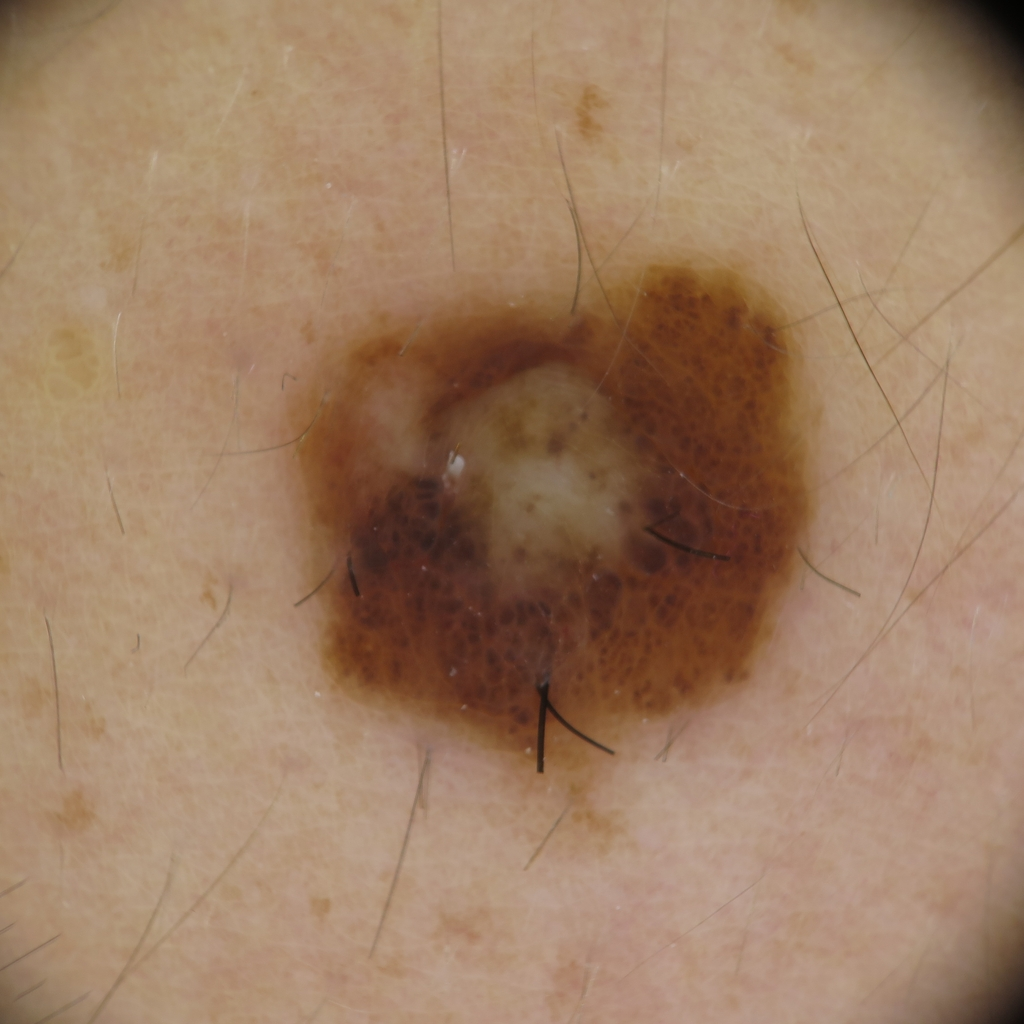

In [ ]:
from IPython.display import Image, clear_output  # to display images
import os
import shutil

Image('/content/ISIC_2019_Training_Input/ISIC_0054704.jpg', width=640)

**LOAD DATA FROM CSV FILE IN DATASET**

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

route = '/content/ISIC_2019_Training_Input/'

metadata = pd.read_csv('/content/drive/MyDrive/skin/ISIC_2019_Training/ISIC_2019_Training_Metadata.csv')

metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/skin/ISIC_2019_Training/ISIC_2019_Training_GroundTruth.csv')

targets = df.columns[1:]
df.image = df.image.apply(lambda row : row + '.jpg')

SEED = 42

im_size = 224
n_labels = 9
batch_size = 32

df

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247.jpg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import os
def seedBasic(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
# tensorflow random seed 
import tensorflow as tf 
def seedTF(seed=SEED):
    tf.random.set_seed(seed)
    
# torch random seed
import torch
def seedTorch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      
# basic + tensorflow + torch 
def seedEverything(seed=SEED):
    seedBasic(seed)
    seedTF(seed)
    seedTorch(seed)

seedEverything(SEED)

**SPLIT TRAIN TEST AND BUILD DATA**

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(df, test_size=0.4, shuffle=True, random_state=SEED)
valid, test = train_test_split(valid, test_size=0.5, shuffle=True, random_state=SEED)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=180,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
train_dataset = train_datagen.flow_from_dataframe(dataframe=train,
                                            directory=route,
                                            x_col="image",
                                            y_col=targets,
                                            batch_size=batch_size,
                                            seed=SEED,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(im_size,im_size))

valid_dataset = test_datagen.flow_from_dataframe(dataframe=valid,
                                            directory=route,
                                            x_col="image",
                                            y_col=targets,
                                            batch_size=batch_size,
                                            seed=SEED,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(im_size,im_size))

test_dataset = test_datagen.flow_from_dataframe(dataframe=test,
                                            directory=route,
                                            x_col="image",
                                            y_col=targets,
                                            batch_size=batch_size,
                                            seed=SEED,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(im_size,im_size))

Found 15198 validated image filenames.
Found 5066 validated image filenames.
Found 5067 validated image filenames.


**LOAD MODEL WITH ATTENTION LAYER**

In [ ]:
!pip install -U keras-cv-attention-models

     |████████████████████████████████| 388 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 51.6 MB/s 
     |████████████████████████████████| 462 kB 49.7 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Activation, Conv2D, Input, GlobalAveragePooling2D, Concatenate, InputLayer, \
ReLU, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, Softmax, Lambda, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Optimizer 
from keras_cv_attention_models import attention_layers

In [ ]:
embedding = attention_layers.PositionalEmbedding()
cls = attention_layers.ClassToken()

In [ ]:
cls

In [ ]:
patch_size = 4
num_patches = 4
projection_dim = 224
inputs = tf.keras.Input(shape = (im_size,im_size,3))

x = Conv2D(filters = 4, kernel_size=(1,1),strides = (1,1),padding = "same",activation = "relu")(inputs)
x = BatchNormalization(axis = -1)(x)
x = Conv2D(filters = 16, kernel_size=(1,1),strides = (1,1),padding = "same",activation = "relu")(inputs)
print(x.shape)
x = embedding(x)
x = tf.image.extract_patches(images=x,
                          sizes=[1, patch_size, patch_size, 1],
                          strides=[1, patch_size, patch_size, 1],
                          rates=[1, 1, 1, 1],
                          padding='VALID') 
x = attention_layers.cot_attention(x,3)


print(x.shape)
x = Conv2D(filters = 512, kernel_size=(3,3),strides = (1,1),padding = "same",activation = "relu")(x)
x = BatchNormalization(axis = -1)(x)
x = attention_layers.cot_attention(x,3)
x = Conv2D(filters = 256, kernel_size=(3,3),strides = (1,1),padding = "same",activation = "relu")(x)
x = BatchNormalization(axis = -1)(x)

x = Conv2D(filters = 128, kernel_size=(1,1),strides = (1,1),padding = "same",activation = "relu")(x)
x = Dense(projection_dim,activation="gelu")(x)

x = attention_layers.cot_attention(x,3)
print(x.shape)
x = GlobalAveragePooling2D()(x)

# print(x.shape)
x = Dense(n_labels,activation="sigmoid")(x)
model = tf.keras.Model(inputs = inputs, outputs = x)


(None, 224, 224, 16)
(None, 56, 56, 256)
(None, 56, 56, 224)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 16  64          ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 positional_embedding (Position  (None, 224, 224, 16  802816     ['conv2d_24[0][0]']              
 alEmbedding)                   )                                                           

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa
f1score = tfa.metrics.F1Score(num_classes=n_labels, average='macro')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),loss= tf.keras.losses.CategoricalCrossentropy(),metrics = ["accuracy",f1score])

**TRAINING MODEL**

In [ ]:
epochs = 50
monitor = "val_loss"
mode = 'min'
save_path = '/content/drive/MyDrive/skin/best.h5'

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,
    patience=10,
    restore_best_weights=True,
    mode=mode
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,
    factor=0.2,
    patience=5,
    verbose=1,
    mode=mode,
    min_lr=1e-5,
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode=mode,
    save_freq="epoch",
)

model.fit_generator(train_dataset,
                    validation_data=valid_dataset,
                    epochs=epochs,
                    steps_per_epoch=len(train)//batch_size,
                    validation_steps=len(valid)//batch_size,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr, checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
474/474 [==============================] - ETA: 0s - loss: 1.2795 - accuracy: 0.5431 - f1_score: 0.1683
Epoch 1: val_loss improved from inf to 1.24982, saving model to /content/drive/MyDrive/skin/best.h5
474/474 [==============================] - 572s 1s/step - loss: 1.2795 - accuracy: 0.5431 - f1_score: 0.1683 - val_loss: 1.2498 - val_accuracy: 0.5724 - val_f1_score: 0.1718 - lr: 1.0000e-04
Epoch 2/50
474/474 [==============================] - ETA: 0s - loss: 1.1060 - accuracy: 0.5973 - f1_score: 0.2041
Epoch 2: val_loss improved from 1.24982 to 1.17243, saving model to /content/drive/MyDrive/skin/best.h5
474/474 [==============================] - 520s 1s/step - loss: 1.1060 - accuracy: 0.5973 - f1_score: 0.2041 - val_loss: 1.1724 - val_accuracy: 0.5868 - val_f1_score: 0.2119 - lr: 1.0000e-04
Epoch 3/50
474/474 [==============================] - ETA: 0s - loss: 1.0443 - accuracy: 0.6193 - f1_score: 0.2690
Epoch 3: val_loss improved from 1.17243 to 1.09199, saving model to /

In [ ]:
drive_path = '/content/best.h5'
shutil.copy(save_path, drive_path)

In [ ]:
model.load_weights("/content/drive/MyDrive/skin/best.h5")

EVALUATE THE MODEL

In [ ]:
model.evaluate(valid_dataset)

159/159 [==============================] - 87s 543ms/step - loss: 0.8106 - accuracy: 0.7357 - f1_score: 0.5245


[0.8106486797332764, 0.7356889247894287, 0.5245137214660645]

In [ ]:
model.evaluate(test_dataset)

159/159 [==============================] - 98s 612ms/step - loss: 0.7742 - accuracy: 0.7482 - f1_score: 0.5444


[0.7742154002189636, 0.7481744885444641, 0.5444302558898926]